# Landslide Detection Challenge - Starter Notebook

Welcome to the Landslide Detection Challenge! This notebook will guide you through:
1. Loading and exploring the multi-band dataset provided in `.npy` format.
2. Visualizing the multi-band satellite data and understanding label distribution.
3. Building and evaluating a baseline model to classify landslide and non-landslide images.

Let’s get started with loading and understanding the data!


## Block 1: Import Libraries

In [1]:
# Import necessary libraries
import os
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-07-28 16:08:10.239224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753718890.414260      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753718890.463219      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Explanation
We import the required libraries:
- **os**: for file and directory handling.
- **numpy**: for numerical operations, particularly for loading `.npy` files.
- **pandas**: for data handling with CSV files.
- **matplotlib.pyplot**: for visualizing data, such as label distributions.
- **sklearn.model_selection.train_test_split**: for splitting data into training and validation sets.
- **tensorflow.keras**: for building and training a neural network model.


## Block 2: Define Paths and Load CSV Files

In [51]:
# Define paths for the dataset (remember to unzip the dataset first!)
train_csv_path = '/kaggle/input/landslide-detection/Train.csv'  # Path to the training labels CSV file
test_csv_path = '/kaggle/input/landslide-detection/Test.csv'    # Path to the test image IDs CSV file
train_data_path = '/kaggle/input/landslide-detection/train_data/train_data'  # Folder where .npy train files are located
test_data_path = '/kaggle/input/landslide-detection/test_data/test_data'    # Folder where .npy test files are located

# Load Train.csv and inspect the data
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
print("Train.csv:")
print(train_df.head())

Train.csv:
          ID  label
0  ID_HUD1ST      1
1  ID_KGE2HY      1
2  ID_VHV9BL      1
3  ID_ZT0VEJ      0
4  ID_5NFXVY      0


In [52]:
train_df.label.value_counts()

label
0    5892
1    1255
Name: count, dtype: int64

### Explanation
- **Define Paths**: Specify paths to `Train.csv`, `Test.csv`, and folders containing `.npy` files for training and testing images.
- **Load Train.csv**: We read the `Train.csv` file, which contains `ID` and `label` columns. The `label` is binary, indicating whether the image contains a landslide (1) or not (0).


## Block 4: Load, Normalize, and Display Sample Multi-band Images

In [54]:
# Function to load and normalize .npy images
def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r')

    img = img.astype('float32')  # ensure float for normalization

    # Normalize per band (channels last)
    min_vals = img.min(axis=(0, 1), keepdims=True)
    max_vals = img.max(axis=(0, 1), keepdims=True)
    img_normalized = (img - min_vals) / (max_vals - min_vals + 1e-8)

    return img_normalized

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

### Explanation
This block provides a complete view of the 12 individual bands with the corrected descriptions for ascending and descending radar bands.

1. **Band Descriptions**:
   - **Bands 1-4**: Visible and Near Infrared bands (Red, Green, Blue, NIR).
   - **Bands 5-8**: Descending radar bands:
     - **Band 5**: Descending VV (Vertical-Vertical polarization).
     - **Band 6**: Descending VH (Vertical-Horizontal polarization).
     - **Band 7**: Descending Diff VV.
     - **Band 8**: Descending Diff VH.
   - **Bands 9-12**: Ascending radar bands:
     - **Band 9**: Ascending VV (Vertical-Vertical polarization).
     - **Band 10**: Ascending VH (Vertical-Horizontal polarization).
     - **Band 11**: Ascending Diff VV.
     - **Band 12**: Ascending Diff VH.

2. **Plotting Layout**:
   - A 3x4 grid layout displays each band as a grayscale image.
   - Each subplot includes the band number and description for easy reference.
   - `plt.subplots_adjust` adds spacing between the plots to improve readability.


In [56]:
# Path to the folder containing .npy images

X = np.array([load_and_normalize_npy_image(image_id, train_data_path) for image_id in train_df['ID']])
y = train_df['label'].values
X_test = np.array([load_and_normalize_npy_image(image_id, test_data_path) for image_id in test_df['ID']])

def extract_features(img):
    # img: (batch, H, W, 12)

    # Bands 1-4: Optical
    red, green, blue, nir = [img[:, :, :, i] for i in range(4)]
    ndvi = (nir - red) / (nir + red + 1e-5)
    ndwi = (green - nir) / (green + nir + 1e-5)

    # Radar Descending
    vv_desc, vh_desc = img[:, :, :, 4], img[:, :, :, 5]
    vv_vh_ratio_desc = (vv_desc + 1e-5) / (vh_desc + 1e-5)

    # Radar Ascending
    vv_asc, vh_asc = img[:, :, :, 8], img[:, :, :, 9]
    vv_vh_ratio_asc = (vv_asc + 1e-5) / (vh_asc + 1e-5)

    # Expand NDVI etc. to (batch, H, W, 1) before concatenation
    ndvi = ndvi[..., np.newaxis]
    ndwi = ndwi[..., np.newaxis]
    vv_vh_ratio_desc = vv_vh_ratio_desc[..., np.newaxis]
    vv_vh_ratio_asc = vv_vh_ratio_asc[..., np.newaxis]

    # Concatenate along channel axis
    features = np.concatenate([img, ndvi, ndwi, vv_vh_ratio_desc, vv_vh_ratio_asc], axis=-1)
    return features


X_features = extract_features(X)
X_features_test = extract_features(X_test)

## Block 5: Prepare Data for Model Training

In [57]:
from PIL import Image
def normalize_to_uint8(arr):
    arr = np.clip(arr, 0, 1)  # ensure within [0,1]
    return (arr * 255).astype(np.uint8)


def image_converter(df, output_dir, X):
    os.makedirs(output_dir, exist_ok=True)
    ids = df['ID'].tolist()
    # Loop through samples and save
    for i in range(X.shape[0]):
        img_arr = X[i, :, :, [0, 1, 3]]  # Expecting (64, 64, 3)
    
        # If it's (3, 64, 64) or other shape, move axes
        if img_arr.shape[0] == 3 and img_arr.shape[-1] != 3:
            img_arr = np.transpose(img_arr, (1, 2, 0))  # (H, W, 3)
    
        img_arr = normalize_to_uint8(img_arr)  # scale to 0–255
    
        img = Image.fromarray(img_arr)
        img.save(os.path.join(output_dir, f"{ids[i]}.png"))
    
    print(f"✅ Saved {X.shape[0]} images to folder: {output_dir}")

train_dir = "kaggle/working/saved_images"
image_converter(train_df, train_dir , X_features)
test_dir = "kaggle/working/test_images"
image_converter(test_df, test_dir, X_features_test)

✅ Saved 7147 images to folder: kaggle/working/saved_images
✅ Saved 5398 images to folder: kaggle/working/test_images


In [58]:
train_df['image_path'] = train_dir + '/' + train_df['ID'] + '.png'
test_df = pd.read_csv(test_csv_path)
test_df['image_path'] = test_dir + '/' + test_df['ID'] + '.png'
display(train_df.head(), test_df.head(), train_df.shape, test_df.shape)

,ID,label,image_path
0,ID_HUD1ST,1,kaggle/working/saved_images/ID_HUD1ST.png
1,ID_KGE2HY,1,kaggle/working/saved_images/ID_KGE2HY.png
2,ID_VHV9BL,1,kaggle/working/saved_images/ID_VHV9BL.png
3,ID_ZT0VEJ,0,kaggle/working/saved_images/ID_ZT0VEJ.png
4,ID_5NFXVY,0,kaggle/working/saved_images/ID_5NFXVY.png


,ID,image_path
0,ID_ICB8K9,kaggle/working/test_images/ID_ICB8K9.png
1,ID_2D4AOJ,kaggle/working/test_images/ID_2D4AOJ.png
2,ID_2TVPI0,kaggle/working/test_images/ID_2TVPI0.png
3,ID_E05WIK,kaggle/working/test_images/ID_E05WIK.png
4,ID_KKFDJO,kaggle/working/test_images/ID_KKFDJO.png


(7147, 3)

(5398, 2)

In [68]:
IMG_SIZE = (300, 300)
BATCH_SIZE = 16
SEED = 42

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED)

# Augmentations for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    validation_split=0.0
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',  # or 'binary' for 2 classes
    seed=SEED,
    shuffle=True
)

# Validation generator
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    seed=SEED,
    shuffle=False
)

test_datagen = ImageDataGenerator()
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed=SEED,
    shuffle=False
    
)

Found 4573 validated image filenames.
Found 1144 validated image filenames.
Found 5398 validated image filenames.


### Explanation

1. **Load Data**:
   - We define `load_npy_image` to load `.npy` files as raw images.
   - `X` is created by loading each image using `load_npy_image` based on the image IDs in `train_df`.
   - `y` contains the labels from `train_df`.

2. **Stratified Data Split**:
   - We split the data into `X_train`, `X_val`, `y_train`, and `y_val` while preserving class distribution using `stratify=y`.

3. **ImageDataGenerator for Training**:
   - `train_datagen` is configured with data augmentation options to increase the diversity of the training data.

4. **ImageDataGenerator for Validation**:
   - `val_datagen` loads the validation data without augmentation.

5. **Generators**:
   - `train_ds` and `val_ds` are created using `.flow()`, which yields data in batches for efficient training and validation.

In [69]:
X_batch, y_batch = train_gen[0]

In [70]:
X_batch.shape

(16, 300, 300, 3)

In [71]:
y_batch

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [72]:
X_val_batch, y_val_batch = val_ds[0]

TypeError: '_PrefetchDataset' object is not subscriptable

In [73]:
X_val_batch.shape, y_val_batch.shape

NameError: name 'X_val_batch' is not defined

## Block 6: Define and Compile a CNN Model with Focal Loss

In [62]:
# Precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Define the Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate focal loss
        fl = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)

    return focal_loss_fixed

model = Sequential([
    # First convolutional block
    Input(shape=X_batch.shape[1:]),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth convolutional block for deeper feature extraction
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Flatten and add dense layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])


# Compile the model with Focal Loss and additional metrics
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy', precision_m, recall_m, f1_m]  # Additional metrics
)


# Compile the model with Focal Loss and additional metrics
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy', precision_m, recall_m, f1_m]  # Additional metrics
)

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 5,118,145 (19.52 MB)

 Trainable params: 5,116,801 (19.52 MB)

 Non-trainable params: 1,344 (5.25 KB)

### Explanation

This code defines a Convolutional Neural Network (CNN) with custom metrics (Precision, Recall, and F1 Score) and **Focal Loss** for training, making it suitable for imbalanced datasets.

#### Key Components

1. **Custom Metrics**:
   - `precision_m`: Calculates the proportion of true positive predictions out of all positive predictions, which helps evaluate the model’s accuracy in predicting positive (landslide) samples.
   - `recall_m`: Measures the proportion of true positives out of all actual positives, reflecting the model’s ability to detect all positive cases.
   - `f1_m`: Combines Precision and Recall into a single score using the harmonic mean, making it useful for evaluating the model on imbalanced datasets.

2. **Focal Loss Function**:
   - Focal Loss is designed to focus on hard-to-classify examples, making it particularly beneficial for imbalanced datasets.
   - Parameters:
     - `gamma=2.0`: Adjusts the focusing mechanism. Higher values place more focus on misclassified examples.
     - `alpha=0.25`: Balances the contribution of positive and negative samples, ensuring the loss calculation doesn’t get dominated by the majority class.
   - The function `focal_loss_fixed` calculates Focal Loss by:
     - Clipping predictions to avoid `log(0)`.
     - Calculating the probability for each prediction (`p_t`), where correct predictions contribute less to the loss.
     - Applying the focal scaling factor `(1 - p_t)^{\gamma}` to emphasize harder examples in the loss computation.

3. **CNN Model Architecture**:
   - The CNN is designed with four convolutional blocks, each containing:
     - **Conv2D layers**: Extract features with increasing complexity as the model goes deeper.
     - **BatchNormalization layers**: Normalize activations, speeding up convergence and improving stability.
     - **MaxPooling2D layers**: Down-sample feature maps, reducing spatial dimensions and capturing abstract patterns.
     - **Dropout layers**: Applied with increasing rates, reducing overfitting by randomly deactivating nodes during training.
   - Following the convolutional blocks:
     - **Flatten**: Converts 2D feature maps to a 1D vector.
     - **Dense layers**: Two fully connected layers with ReLU activation capture higher-level features, with Dropout for regularization.
     - **Sigmoid Output Layer**: Used for binary classification, outputs the probability of each class (No Landslide or Landslide).

4. **Model Compilation**:
   - `optimizer='adam'`: An adaptive optimizer that adjusts the learning rate automatically during training.
   - `loss=focal_loss(gamma=2.0, alpha=0.25)`: Focal Loss to handle class imbalance.
   - `metrics=['accuracy', precision_m, recall_m, f1_m]`: Additional metrics for a comprehensive evaluation of the model's performance on imbalanced data.

5. **Model Summary**:
   - `model.summary()` displays the model’s architecture, showing layer types, output shapes, and parameter counts. This summary helps verify that the model structure matches expectations before training begins.

## Block 7: Train the Model

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# Create a checkpoint callback that saves the best model based on validation loss
callback = [ModelCheckpoint(
                "kaggle/working/best_model.h5",            
                monitor='val_loss',   
                verbose=1,                  
                save_best_only=True,       
                mode='min'),
            
            EarlyStopping(
                monitor='val_loss', patience=5)
           ]

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = dict(enumerate(class_weights))
# Train the model using the generators with the checkpoint callback
#history = model.fit(
    train_gen,       # Train generator
    epochs=50,
    validation_data=val_ds,  # Validation generator
    callbacks=[callback],  # Include the checkpoint callback in training
)


IndentationError: unexpected indent (2801000097.py, line 19)

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20
N_SPLITS = 5

# ✅ Encode labels
class_names = sorted(train_df['label'].unique())
label_to_index = {name: i for i, name in enumerate(class_names)}
train_df['label_idx'] = train_df['label'].map(label_to_index)

paths = train_df['image_path'].values
labels = train_df['label_idx'].values

# ✅ Load function
def load_image(path, label, training=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)

    return img, label


def build_dataset(x_paths, y_labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x_paths, y_labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1024, seed=42)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# ✅ Model
def build_efficientnetb3():
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False 
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ✅ StratifiedKFold loop
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(paths, labels)):
    print(f"\n🔹 Fold {fold+1}/{N_SPLITS}")
    
    train_paths, val_paths = paths[train_idx], paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    train_ds = build_dataset(train_paths, train_labels, training=True)
    val_ds = build_dataset(val_paths, val_labels, training=False)

    # ✅ Compute class weights for this fold
    cw_values = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(cw_values))
    print("Class Weights:", class_weights)

    # ✅ Build and train model
    model = build_efficientnetb3()
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
    ]

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # Get predictions
    y_true = []
    y_pred = []
    
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    
    # Compute F1
    f1 = f1_score(y_true, y_pred) 
    print("Validation F1 Score:", f1)
    del model
    gc.collect()
    tf.keras.backend.clear_session()


🔹 Fold 1/5
Class Weights: {0: 0.6064323607427056, 1: 2.8489096573208723}
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 178s 611ms/step - accuracy: 0.6053 - loss: 0.6035 - val_accuracy: 0.6820 - val_loss: 0.6788
Epoch 2/20


### Explanation

1. **Model Training**:
   - `model.fit` is updated to use the `train_generator` and `val_generator`.
   - `steps_per_epoch` and `validation_steps` control how many batches are processed per epoch for training and validation.
2. **Efficiency**:
   - Using a generator allows the model to load data in batches, reducing memory usage and making training feasible for large datasets.

## Block 8: Plot Training and Validation Accuracy

In [64]:
def evaluate_model(model, X_test):

    # Predict probabilities
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    # Compute F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Detailed report
    print(classification_report(y_test, y_pred))


In [82]:
predictions = model.predict(test_ds)
y_pred = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='binary'))

338/338 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step


NameError: name 'y_test' is not defined

In [25]:
def threshold_tuning(model):
    scores = []
    thresholds = np.linspace(0.1, 1, 10)
    for thresh in thresholds:
        y_pred = model.predict(X_test)
        y_tuned = (y_pred > thresh).astype(int)
        scores.append(f1_score(y_test, y_tuned))

    fig = px.line(x=thresholds, y=scores, title='Threshold Tuning', template='plotly_white')
    fig.update_traces(line=dict(color='red'))
    fig.update_layout(xaxis_title='Thresholds',
                      yaxis_title='F1 Scores',
                      height=500,
                      width=800)
    
    fig.show()

threshold_tuning(model)

45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


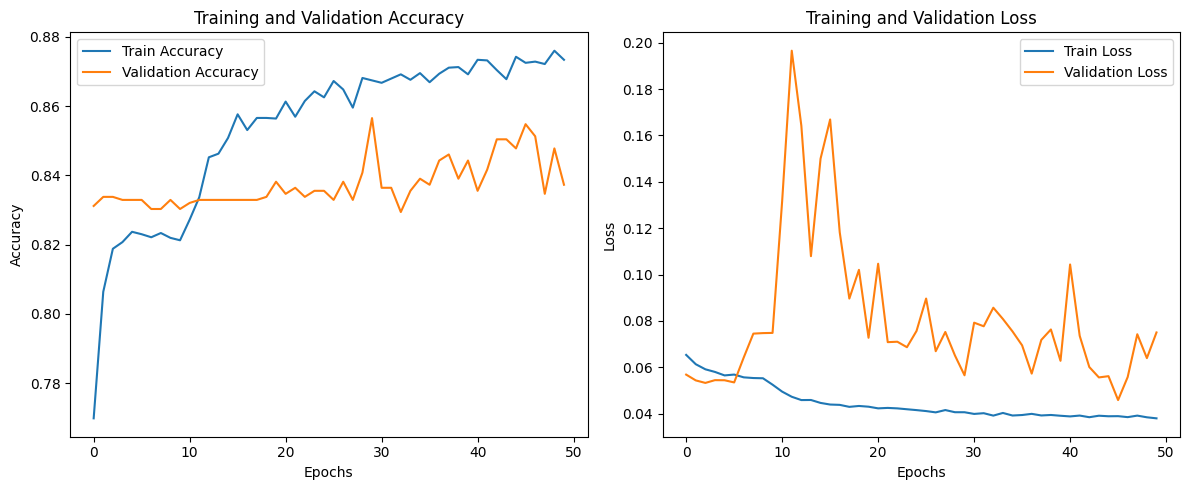

In [98]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


### Explanation
This plot shows the **training and validation accuracy** as well as the **training and validation loss** over the epochs, allowing us to visually inspect the model’s learning behavior:

- **Steady Improvements in Both Accuracy and Loss**: Consistent increases in accuracy and decreases in loss for both training and validation sets indicate effective learning and good generalization.

- **Divergence Between Training and Validation Metrics**:
  - If **training accuracy is high** but **validation accuracy is much lower** (with validation loss increasing), this suggests **overfitting**. The model may perform well on training data but fails to generalize to new data.
  - If both **training and validation accuracy remain low** and losses are high, this indicates **underfitting**, meaning the model may not be complex enough to capture patterns in the data.

This combined plot of accuracy and loss offers a comprehensive view of model performance, helping us assess both how well the model fits the training data and how well it generalizes to new, unseen data.


## Ensemble Methods

In [4]:
def load_image(image_id, folder_path):
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path, mmap_mode='r')
    img = img.astype('float32')
    return img

X = np.array([load_image(image_id, train_data_path) for image_id in train_df['ID']])
y = train_df['label'].values

In [5]:
def extract_features(img):
    # img: (batch, H, W, 12)

    # Bands 1-4: Optical
    red, green, blue, nir = [img[:, :, :, i] for i in range(4)]
    ndvi = (nir - red) / (nir + red + 1e-5)
    ndwi = (green - nir) / (green + nir + 1e-5)

    # Radar Descending
    vv_desc, vh_desc = img[:, :, :, 4], img[:, :, :, 5]
    vv_vh_ratio_desc = (vv_desc + 1e-5) / (vh_desc + 1e-5)

    # Radar Ascending
    vv_asc, vh_asc = img[:, :, :, 8], img[:, :, :, 9]
    vv_vh_ratio_asc = (vv_asc + 1e-5) / (vh_asc + 1e-5)

    # Expand NDVI etc. to (batch, H, W, 1) before concatenation
    ndvi = ndvi[..., np.newaxis]
    ndwi = ndwi[..., np.newaxis]
    vv_vh_ratio_desc = vv_vh_ratio_desc[..., np.newaxis]
    vv_vh_ratio_asc = vv_vh_ratio_asc[..., np.newaxis]

    # Concatenate along channel axis
    features = np.concatenate([img, ndvi, ndwi, vv_vh_ratio_desc, vv_vh_ratio_asc], axis=-1)
    return features


X_features = extract_features(X)

In [124]:
def means(df, X):
    # Bands 4 to 12 → index 3 to 11
    for i, band in enumerate(range(3, 12)):
        df[f'band{band+1}_mean'] = X[:, :, :, band].mean(axis=(1, 2))
        df[f'band{band+1}_std']  = X[:, :, :, band].std(axis=(1, 2))
        df[f'band{band+1}_min']  = X[:, :, :, band].min(axis=(1, 2))
        df[f'band{band+1}_max']  = X[:, :, :, band].max(axis=(1, 2))

    # Derived features (NDVI, NDWI, radar)
    for name, idx in zip(['ndvi', 'ndwi', 'vv_vh_desc', 'vv_ch_asc'], [12, 13, 14, 15]):
        df[f'{name}_mean'] = X[:, :, :, idx].mean(axis=(1, 2))
        df[f'{name}_std']  = X[:, :, :, idx].std(axis=(1, 2))
        df[f'{name}_min']  = X[:, :, :, idx].min(axis=(1, 2))
        df[f'{name}_max']  = X[:, :, :, idx].max(axis=(1, 2))

    return df


# Apply to training dataframe
training_df = means(train_df, X_features)

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import optuna
from sklearn.preprocessing import StandardScaler

X_df = training_df.drop(columns=['ID','label'])
y_df = training_df['label']
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df)
xgb =XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [126]:
from sklearn.metrics import f1_score, accuracy_score
def cross_validate_model(model, X, y, n_splits=5, random_state=42):

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_preds = np.zeros_like(y, dtype=float)
    f1_scores, acc_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        # Fit model
        model.fit(X_train, y_train)
        
        # Predict probabilities or classes
        y_pred = model.predict(X_val)
        
        # Save OOF predictions
        oof_preds[val_idx] = y_pred
        
        # Compute metrics
        f1 = f1_score(y_val, y_pred, average='binary')
        acc = accuracy_score(y_val, y_pred)
        f1_scores.append(f1)
        acc_scores.append(acc)
        
        print(f"Fold {fold+1} F1: {f1:.4f} | Accuracy: {acc:.4f}")
    
    print("="*40)
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
    

cross_validate_model(xgb, X_val, y_val)

Fold 1/5
Fold 1 F1: 0.7273 | Accuracy: 0.9162
Fold 2/5
Fold 2 F1: 0.8361 | Accuracy: 0.9441
Fold 3/5
Fold 3 F1: 0.7179 | Accuracy: 0.9076
Fold 4/5
Fold 4 F1: 0.7273 | Accuracy: 0.9076
Fold 5/5
Fold 5 F1: 0.7027 | Accuracy: 0.9076
Mean F1 Score: 0.7423
Mean Accuracy: 0.9166


F1 Score: 0.9460



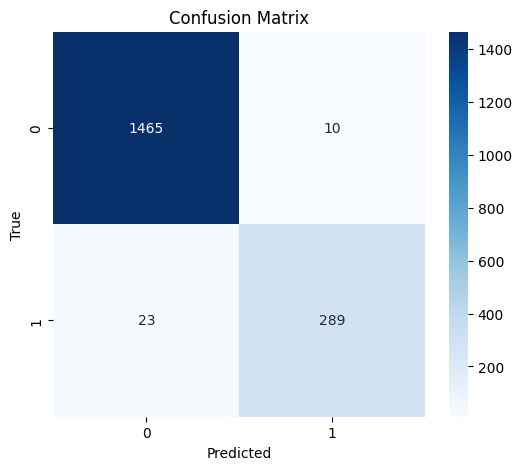

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1475
           1       0.97      0.93      0.95       312

    accuracy                           0.98      1787
   macro avg       0.98      0.96      0.97      1787
weighted avg       0.98      0.98      0.98      1787



In [127]:
def evaluate_model(model, X_test, y_test):

    # Predict probabilities
    y_pred = model.predict(X_test)

    # Compute F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Detailed report
    print(classification_report(y_test, y_pred))


evaluate_model(xgb, X_val, y_val)

In [128]:
from optuna.samplers import RandomSampler
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "random_state": 42,

    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    model = XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
        )

    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred))

    return np.mean(f1_scores)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

study = optuna.create_study(direction="maximize", sampler=RandomSampler())
study.optimize(objective, n_trials=30)

print("Best F1:", study.best_value)
print("Best Params:", study.best_params)

Best F1: 0.8109965635738831
Best Params: {'max_depth': 10, 'learning_rate': 0.1100097528337425, 'subsample': 0.8030855140644414, 'colsample_bytree': 0.809937519997022, 'min_child_weight': 9.095182821346128, 'gamma': 0.869776672831522, 'reg_lambda': 7.584176461762468e-06, 'reg_alpha': 0.6608128442531395}


In [129]:
best_xgb = XGBClassifier(**study.best_params)
cross_validate_model(best_xgb, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.7500 | Accuracy: 0.9179
Fold 2/5
Fold 2 F1: 0.7859 | Accuracy: 0.9319
Fold 3/5
Fold 3 F1: 0.8249 | Accuracy: 0.9422
Fold 4/5
Fold 4 F1: 0.8129 | Accuracy: 0.9403
Fold 5/5
Fold 5 F1: 0.8033 | Accuracy: 0.9328
Mean F1 Score: 0.7954
Mean Accuracy: 0.9330


In [130]:
def threshold_tuning(model, X_test, y_test):
    scores = []
    thresholds = np.linspace(0.1, 1, 10)
    for thresh in thresholds:
        y_pred = model.predict_proba(X_test)[:, 1]
        y_tuned = (y_pred > thresh).astype(int)
        scores.append(f1_score(y_test, y_tuned))

    fig = px.line(x=thresholds, y=scores, title='Threshold Tuning', template='plotly_white')
    fig.update_traces(line=dict(color='red'))
    fig.update_layout(xaxis_title='Thresholds',
                      yaxis_title='F1 Scores',
                      height=500,
                      width=800)
    
    fig.show()

threshold_tuning(best_xgb, X_val, y_val)

## LGB

In [131]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# 1️⃣ Train LightGBM
lgb_model = LGBMClassifier(n_estimators=500, max_depth=-1, learning_rate=0.05)
lgb_model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=500)

In [132]:
cross_validate_model(lgb_model, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.7759 | Accuracy: 0.9272
Fold 2/5
Fold 2 F1: 0.8258 | Accuracy: 0.9422
Fold 3/5
Fold 3 F1: 0.8531 | Accuracy: 0.9515
Fold 4/5
Fold 4 F1: 0.8324 | Accuracy: 0.9459
Fold 5/5
Fold 5 F1: 0.8464 | Accuracy: 0.9468
Mean F1 Score: 0.8267
Mean Accuracy: 0.9427


In [133]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "verbose": -1
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []


    model = LGBMClassifier(**params, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='binary_logloss',
        callbacks=[]
        )

    y_pred = model.predict(X_val)
    f1_scores.append(f1_score(y_val, y_pred))

    return np.mean(f1_scores)

    return np.mean(f1_scores)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best F1:", study.best_value)
print("Best Params:", study.best_params)

best_params = study.best_params

Best F1: 0.8336134453781513
Best Params: {'n_estimators': 209, 'learning_rate': 0.09943301853020742, 'max_depth': 8, 'num_leaves': 20, 'subsample': 0.6428327755277707, 'colsample_bytree': 0.8905540821843367, 'min_child_samples': 6}


In [144]:
best_lgbm = LGBMClassifier(**study.best_params)
cross_validate_model(best_lgbm, X_train, y_train)

Fold 1/5
Fold 1 F1: 0.7450 | Accuracy: 0.9170
Fold 2/5
Fold 2 F1: 0.8057 | Accuracy: 0.9366
Fold 3/5
Fold 3 F1: 0.8319 | Accuracy: 0.9450
Fold 4/5
Fold 4 F1: 0.8409 | Accuracy: 0.9478
Fold 5/5
Fold 5 F1: 0.7989 | Accuracy: 0.9319
Mean F1 Score: 0.8045
Mean Accuracy: 0.9356


## Block 9: Make Predictions on the Test Set and Prepare Submission

In [ ]:
def load_and_extract_features(df, train_data_path):
    def load_image(image_id):
        path = os.path.join(train_data_path, f"{image_id}.npy")
        return np.load(path, mmap_mode='r').astype('float32')

    X = np.array([load_image(image_id) for image_id in train_df['ID']])

    # ✅ Compute stats directly (no external mean_fn needed)
    for i, band in enumerate(range(3, 12)):
        df[f'band{band+1}_mean'] = X[:, :, :, band].mean(axis=(1, 2))
        df[f'band{band+1}_std']  = X[:, :, :, band].std(axis=(1, 2))
        df[f'band{band+1}_min']  = X[:, :, :, band].min(axis=(1, 2))
        df[f'band{band+1}_max']  = X[:, :, :, band].max(axis=(1, 2))

    # Derived features (NDVI, NDWI, radar)
    for name, idx in zip(['ndvi', 'ndwi', 'vv_vh_desc', 'vv_ch_asc'], [12, 13, 14, 15]):
        df[f'{name}_mean'] = X[:, :, :, idx].mean(axis=(1, 2))
        df[f'{name}_std']  = X[:, :, :, idx].std(axis=(1, 2))
        df[f'{name}_min']  = X[:, :, :, idx].min(axis=(1, 2))
        df[f'{name}_max']  = X[:, :, :, idx].max(axis=(1, 2))

    return df

X_pred = load_and_extract_features(test_df, test_data_path)
X_preds = X_pred.drop('ID', axis=1)

In [147]:
X_train.shape

(5360, 52)

In [142]:
def stratifiedKFold(model):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    test_preds = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {fold+1}")
    
        # Use the same DataFrames as in split
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
        )
    
        # Validation predictions and F1
        y_pred_val = model.predict(X_val)
        f1 = f1_score(y_val, y_pred_val)
        f1_scores.append(f1)
        print(f"Fold {fold+1} F1: {f1:.4f}")
    
        # Test predictions (probabilities)
        y_pred_test = model.predict_proba(X_preds)[:, 1]
        test_preds.append(y_pred_test)
    
    # ✅ Average test predictions from 5 folds
    final_test_preds = np.mean(test_preds, axis=0)
    
    # ✅ Convert to class labels with custom threshold
    final_labels = (final_test_preds >= 0.4).astype(int)
    
    print("CV Mean F1:", np.mean(f1_scores))
    return final_labels

In [145]:
y_pred = stratifiedKFold(best_lgbm)

Fold 1
Fold 1 F1: 0.7450


ValueError: Number of features of the model must match the input. Model n_features_ is 52 and input n_features is 56

In [122]:

test_ids = test_df['ID'].values
# Predict probabilities and classify as 0 or 1

# Count the number of predictions for each class
unique, counts = np.unique(y_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)

# Prepare submission file
submission_df = pd.DataFrame({
    'ID': test_ids,
    'label': y_pred.flatten()  # Flatten to match submission format
})
submission_df.to_csv('/kaggle/working/Submission_File.csv', index=False)
print("Sample submission file created as 'Submission_File.csv'.")

Prediction counts: {0: 4749, 1: 649}
Sample submission file created as 'Submission_File.csv'.


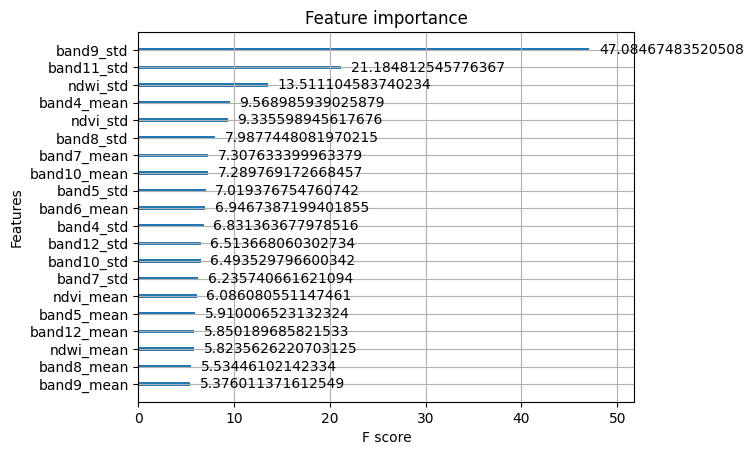

In [54]:
from xgboost import plot_importance
plot_importance(best_xgb, importance_type='gain', max_num_features=20)
plt.show()

## Transfer Learning

In [56]:
X_train.shape

(5717, 64, 64, 12)

In [71]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Flatten
resnet_model = ResNet50(
    include_top=False,  
    weights=None,     
    input_shape=(X_train.shape[1:])
)

for layer in resnet_model.layers:
    layer.trainable = False

# Build classification head
inputs = Input(shape=X_train.shape[1:])
x = resnet_model(inputs, training=False)  # Keep batchnorm frozen
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

rs_model = Model(inputs, outputs)

rs_model.compile(optimizer='adam',
             loss = focal_loss(gamma=2.0, alpha=0.5),
             metrics = ['accuracy', f1_m])

rs_model.fit(train_ds, 
             epochs=15,
             validation_data=val_ds,
             class_weight=class_weights_dict
        
)

Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 51s 397ms/step - accuracy: 0.7213 - f1_m: 9.2602 - loss: 0.0694 - val_accuracy: 0.8329 - val_f1_m: 0.0000e+00 - val_loss: 0.0589
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.8256 - f1_m: 2.1839 - loss: 0.0529 - val_accuracy: 0.8329 - val_f1_m: 0.0000e+00 - val_loss: 0.0575
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.8263 - f1_m: 2.9585 - loss: 0.0525 - val_accuracy: 0.8329 - val_f1_m: 0.0000e+00 - val_loss: 0.0577
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.8187 - f1_m: 2.0502 - loss: 0.0537 - val_accuracy: 0.8329 - val_f1_m: 0.0000e+00 - val_loss: 0.0635
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - accuracy: 0.8278 - f1_m: 2.1218 - loss: 0.0514 - val_accuracy: 0.8329 - val_f1_m: 0.0000e+00 - val_loss: 0.0544
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.8242 - f1_m: 2.6313 - loss: 0.0524 - val_accuracy: 0.8329 - val_f1_m: 0.0000e+00 - val_loss: 0.062

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step
F1 Score: 0.0079



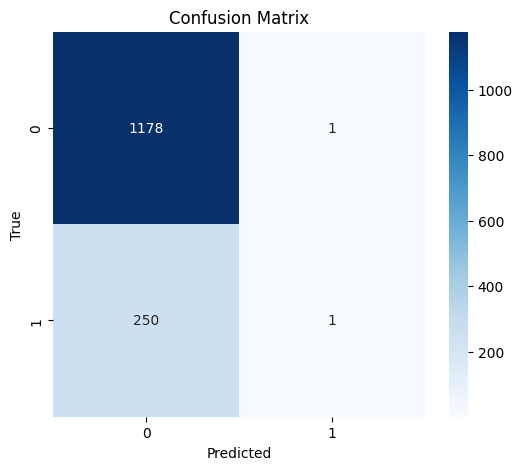

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1179
           1       0.50      0.00      0.01       251

    accuracy                           0.82      1430
   macro avg       0.66      0.50      0.46      1430
weighted avg       0.77      0.82      0.75      1430



(0.007905138339920948,
 array([[1178,    1],
        [ 250,    1]]))

In [72]:
evaluate_model(rs_model, X_test)

### Explanation
1. **Count Predictions**:
   - After making predictions on `X_test`, we use `np.unique` with `return_counts=True` to count the occurrences of `0`s and `1`s in `y_test_pred`.
   - We print the counts, which shows the distribution of predicted labels.

2. **Interpretation**:
   - The counts provide insight into whether the model is predicting a balanced number of `0`s and `1`s or if it's skewed towards one class.
   - Please consider that the test set is imbalanced towards the non-landslide class.
   - This check is particularly useful for binary classification problems where class imbalance could impact the model’s evaluation.

3. **Prepare Submission File**:
   - The `Submission_File.csv` file is created in the same way, ready for submission.